In [68]:
import yaml
import glob
import numpy as np
import pickle
import pandas as pd


In [69]:
LABEL = 'taken'
FEATURES_TO_DISCRETIZE = ['to_user_distance','to_user_elevation','total_earning','to_user_elevation']
DISCRETE_FEATURES = ['day_of_week']


In [70]:
df = pd.read_csv('../dataset/raw_dataset.csv')


In [71]:
df['day_of_week'] = pd.to_datetime(df['created_at']).apply(lambda x: '{dayofweek}'.format(dayofweek=x.dayofweek)).astype(str)


In [ ]:
quantiles = [0, .5, .75, .9, 1.]

#discrete features
discretized_dataset = df[DISCRETE_FEATURES].astype(str)

#get quantiles for each column
for feature in FEATURES_TO_DISCRETIZE:
    discretized_dataset[feature] = pd.qcut(df[feature], q=quantiles, labels=range(1,len(quantiles)))

#one-hot encoding
discretized_dataset = pd.get_dummies(discretized_dataset)

discretized_dataset[LABEL] = pd.to_numeric(df[LABEL])

#print result
discretized_dataset

In [72]:
discretized_dataset = pd.DataFrame()

discretized_dataset = pd.get_dummies(df[DISCRETE_FEATURES])

for feature in FEATURES_TO_DISCRETIZE:
    discretized_dataset[feature]=df[feature]

discretized_dataset[LABEL] = df[LABEL]

In [73]:
discretized_dataset.to_pickle('../dataset/discretized_dataset')

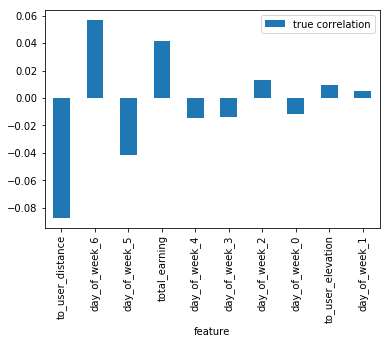

In [75]:
# Features correlation coefficent to label
fi = pd.DataFrame({'feature': list(discretized_dataset),
                   'correlation': discretized_dataset.corr()[LABEL].abs(),
                   'true correlation': discretized_dataset.corr()[LABEL]}).\
                    sort_values('correlation', ascending = False)

fi[fi.feature!=LABEL].head(10).plot.bar(x='feature', y ='true correlation')